In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from torch.nn import functional as F
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


(آ)

In [3]:
batch_size = 400

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# define trainset Cifar and transform it
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# label == 0 is for plane and label == 1 is for car and modify the trianset data
train_indices = [i for i, label in enumerate(trainset.targets) if label == 0 or label == 1]
trainset.targets = [trainset.targets[i] for i in train_indices]
trainset.data = trainset.data[train_indices]

# modify the testset data
test_indices = [i for i, label in enumerate(testset.targets) if label == 0 or label == 1]
testset.targets = [testset.targets[i] for i in test_indices]
testset.data = testset.data[test_indices]

# define dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=0)

classes = ('plane', 'car')

Files already downloaded and verified
Files already downloaded and verified


2
torch.Size([400, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '0')

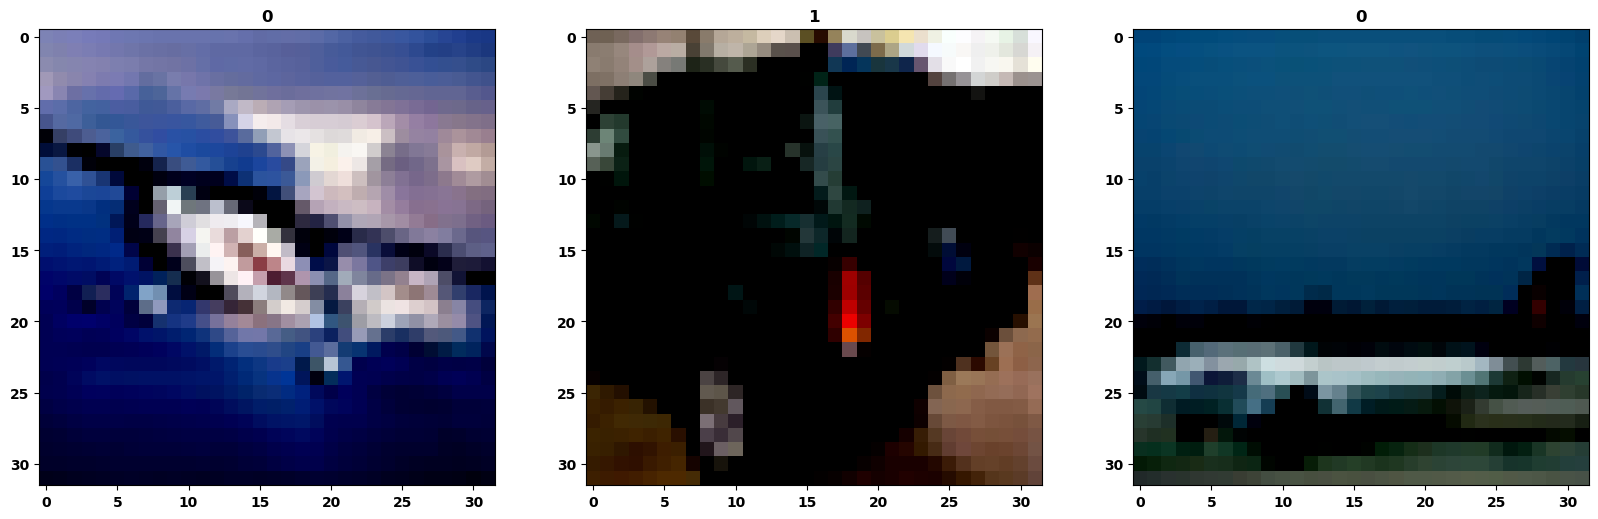

In [4]:
for i, data in enumerate(trainloader, 0):
    print(len(data))
    images, label= data
    print(images.shape)
    break
# show three images of the first itteration 
_,axes = plt.subplots( 1,3 , figsize=(20, 10))
i = random.randint(0, batch_size-1)
images = images.permute(0,2, 3, 1) 
axes[0].imshow(images[i])
axes[0].set_title(f'{label[i]}')

axes[1].imshow(images[i+1])
axes[1].set_title(f'{label[i+1]}')

axes[2].imshow(images[i+2])
axes[2].set_title(f'{label[i+2]}')

In [5]:
# select pretrained resnet50 system model
model = torchvision.models.resnet50(pretrained=True)

# define a Fc layer with 2 output
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(classes))


# devide model to Fc layer and the rest of the network
model_N = torch.nn.Sequential(*list(model.children())[:-1])
# freeze the rest of the model
for param in model_N.parameters():
    param.requires_grad = False

# define fullt connected layer
model_fc = model.fc


f:\program-files\Anaconda\envs\Ahmad\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\program-files\Anaconda\envs\Ahmad\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
number_of_epoch = 10
loss_values = []
accuracy_values = []
for epoch in (range(number_of_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    total = 0
    correct = 0

    for inputs, labels in tqdm(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # the input size is (batch_size , 3 , 32 ,32)
        # zero the parameter gradients
        optimizer.zero_grad()

        # pass the input from the freezed model(feature extractor)
        in_temp = model_N(inputs)

        # pass the reshaped output of the freezed model to the fc layer
        outputs = model_fc(in_temp.view(in_temp.size(0), -1))

        # define loss
        loss = criterion(outputs, labels)
        # optimize the fc layer 
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        # pridiction 
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    
    # lists for plot the result
    loss_values.append(running_loss / total)
    accuracy_values.append(100 * correct / total)    

    print(f'ecpoch:{epoch+1}, loss:{running_loss/ total}, accuracy:{100 * correct / total}')

print('Finished Training')


100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


ecpoch:1, loss:0.0011148648023605347, accuracy:82.03


100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


ecpoch:2, loss:0.00099122414290905, accuracy:84.07


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


ecpoch:3, loss:0.0009433922916650772, accuracy:85.02


100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


ecpoch:4, loss:0.000891277465224266, accuracy:86.02


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


ecpoch:5, loss:0.0008654384702444077, accuracy:86.46


100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


ecpoch:6, loss:0.0008456913083791733, accuracy:86.61


100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


ecpoch:7, loss:0.0008331274837255478, accuracy:86.82


100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


ecpoch:8, loss:0.0008240993916988373, accuracy:86.9


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


ecpoch:9, loss:0.0008055747658014297, accuracy:87.25


100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

ecpoch:10, loss:0.0007980640798807144, accuracy:87.47
Finished Training


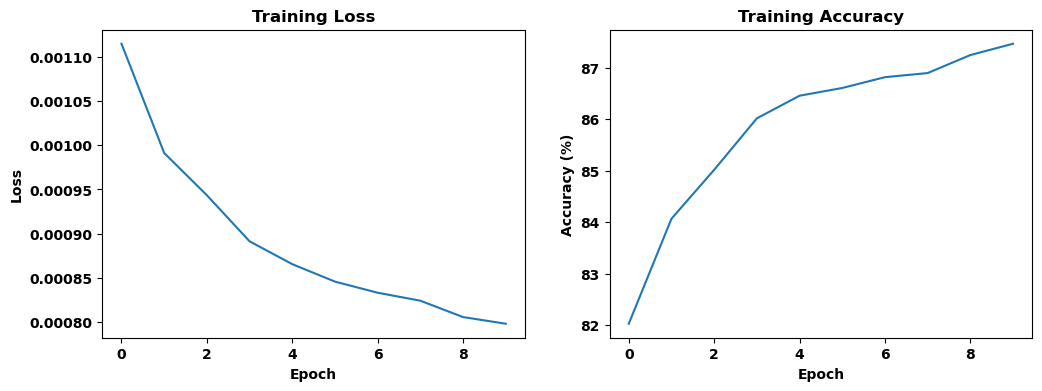

In [9]:
# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [10]:
# define the final model
model_final = torch.nn.Sequential(
    model_N,
    torch.nn.Flatten(),
    model_fc
)

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = model_final(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train dataset:{100 * correct / total}')

Accuracy of the network on the train dataset:87.45


(ب)

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_final(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test dataset:{100 * correct / total}')

Accuracy of the network on the test dataset:87.7
